# Driver Identification using ResNet50 and GRU (RNN)

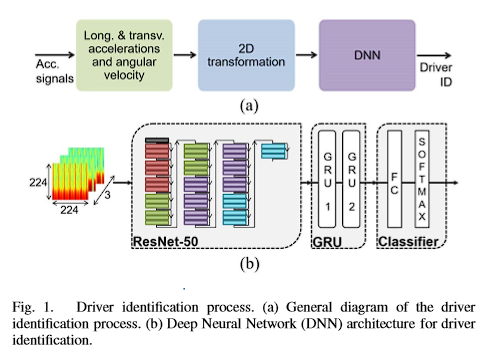

In [1]:
import numpy as np
import pandas as pd
import torch

In [2]:
X = np.load('./data/feature_maps_labels/full_feature_maps.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('./data/feature_maps_labels/full_labels.npy')
y = torch.tensor(y, dtype=torch.float32)
seq_info = pd.read_csv('./data/feature_maps_labels/sequence_info.csv')

Looking out the printout below, you can see the number of sequential windows for each journey. Journey here is defined for each user, at each segment at each position. It's small now because of how tiny the sample is. When it get big, we could try dropping the last window since it was interpolated as that puts in too much noise

In [3]:
seq_info.groupby(['user', 'segment', 'position']).count()#.sum()#.T

window_index
user  segment position              
User1 5       Bag                  5
              Hand                 5
              Hips                 5
              Torso                5
      7       Bag                  4
              Hand                 4
              Hips                 4
              Torso                4
      9       Bag                  2
              Hand                 2
              Hips                 2
              Torso                2
User2 64      Bag                  9
              Hand                 9
              Hips                 9
              Torso                9
      66      Bag                  1
              Hand                 1
              Hips                 1
              Torso                1
      70      Bag                  3
              Hand                 3
              Hips                 3
              Torso                3
      73      Bag                  3
              Hand                 3
              Hips                 3
              Torso                3

In [4]:
window_idx = seq_info.groupby(['user', 'segment', 'position']).count()['window_index'].values
window_idx

array([5, 5, 5, 5, 4, 4, 4, 4, 2, 2, 2, 2, 9, 9, 9, 9, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3], dtype=int64)

~~I'll be using packed sequences to handle the variable length of the sequences. First we need to get a list of tensors based on the grouping above.~~

For now, we'll be taking each 224x224 as a sequence on it's own. When it's time to improve the model, we'll look at trying this out but I doubt it'll help.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split

In [6]:
X.shape, y.shape

(torch.Size([732, 3, 224, 224]), torch.Size([732]))

In [7]:
class FeatureMapDataset(Dataset):
      def __init__(self, feature_maps, labels):
            self.feature_maps = feature_maps
            self.labels = labels

      def __len__(self):
            return len(self.feature_maps)

      def __getitem__(self, idx):
            return self.feature_maps[idx], self.labels[idx]


I've decided to use a k-fold cross validation here and not a holdout set as I did in the previous Simple CNN. I'd work on that again and see if using k-fold improves my prediction.

In [8]:
# Split data into train/val/test
train_val_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42, stratify=y)

train_val_data = FeatureMapDataset(X[train_val_idx], y[train_val_idx])
test_data = FeatureMapDataset(X[test_idx], y[test_idx])

In [9]:
# Initialize KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Prepare test DataLoader
batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
class ResNet50_GRU(nn.Module):
      def __init__(self, hidden_size=512, num_classes=3):
            super(ResNet50_GRU, self).__init__()

            # Load pre-trained ResNet-50 model
            self.resnet50 = models.resnet50(weights='DEFAULT')

            # Freeze ResNet-50 layers
            for param in self.resnet50.parameters():
                  param.requires_grad = False

            # Remove the fully connected layer of ResNet-50
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            
            # Add Batch Normalization and Dropout layers
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(0.5)

            # Define a GRU layer
            self.gru = nn.GRU(input_size=2048, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=0.5)

            # Define fully connected and sigmoid layers
            self.fc = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
            batch_size, C, H, W = x.size()

            # Extract features using ResNet-50
            features = self.resnet50(x)
            
            # Apply batch normalization and dropout
            features = self.batch_norm(features)
            features = self.dropout(features)
            
            # Reshape features to (batch_size, 7*7, 2048) for GRU input
            features = features.view(batch_size, 7*7, 2048)
            
            # Pass the features through GRU
            gru_out, _ = self.gru(features)
            
            # Take the output of the last time step
            gru_out = gru_out[:, -1, :]
            
            # Fully connected layer
            out = self.fc(gru_out)
            
            return out


In [11]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda', save_path=None):
      # criterion = nn.BCELoss()
      # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
      # implement a scheduler if neccesary
      
      train_losses = []
      val_losses = []
      train_accuracies = []
      val_accuracies = []

      for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0

            #print('  Training')
            for inputs, labels in train_loader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  #print('\t',inputs.shape, labels.shape)
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  #print(f'  {outputs.shape}, {outputs.squeeze().shape}')
                  loss = criterion(outputs, labels.long())
                  loss.backward()
                  optimizer.step()
                  
                  running_train_loss += loss.item()
                  _, predicted = torch.max(outputs, 1)
                  correct_train += (predicted == labels).sum().item()
                  total_train += labels.size(0)
            
            train_loss = running_train_loss / len(train_loader)
            train_accuracy = correct_train / total_train
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation phase
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                  #print('  Val')
                  for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        #print('\t',inputs.shape, labels.shape)
                        outputs = model(inputs)
                        #print(f'  {outputs.shape}, {outputs.squeeze().shape}')
                        loss = criterion(outputs, labels.long())
                        running_val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        correct_val += (predicted == labels).sum().item()
                        total_val += labels.size(0)

            val_loss = running_val_loss / len(val_loader)
            val_accuracy = correct_val / total_val
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            scheduler.step()

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Train Acc: {train_accuracy}, Val Loss: {val_loss}, Val Acc: {val_accuracy}")

            # Save checkpoint
            if save_path:
                  torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
                  }, save_path)

      return model, train_losses, val_losses, train_accuracies, val_accuracies


# Evaluate on test set
def test(model, test_loader, device='cuda'):
      model.eval()
      correct_test = 0
      total_test = 0
      with torch.no_grad():
            for inputs, labels in test_loader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  _, predicted = torch.max(outputs, 1)
                  correct_test += (predicted == labels).sum().item()
                  total_test += labels.size(0)
      
      test_accuracy = correct_test / total_test
      print(f"Test Accuracy: {test_accuracy}")
      return test_accuracy

<font color='yellow'>

* save model at different checkpoints
* add list to save in history for each fold (remember to save `loss_hist` and `acc_hist`)
* hyperparameters

</font>

In [12]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
learning_rate_decay = 0.95

In [13]:
loss_hist = []
acc_hist = []


# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_idx)):
      print(f"Fold {fold + 1}/{num_folds}")

      # Subset the dataset for train and validation
      train_subset = Subset(train_val_data, train_idx)
      val_subset = Subset(train_val_data, val_idx)

      # Create DataLoaders
      train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

      # Initialize the model and move it to the device
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      model = ResNet50_GRU().to(device)
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: learning_rate * (learning_rate_decay ** epoch))

      # Train and evaluate the model
      trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device=device
      )

      loss_hist.append([train_losses, val_losses])
      acc_hist.append([train_accuracies, val_accuracies])
      

Fold 1/5
Epoch 1/10, Train Loss: 1.1099480787913005, Train Acc: 0.28846153846153844, Val Loss: 1.1255425065755844, Val Acc: 0.17094017094017094
Epoch 2/10, Train Loss: 1.103774611155192, Train Acc: 0.30128205128205127, Val Loss: 1.105680137872696, Val Acc: 0.3076923076923077
Epoch 3/10, Train Loss: 1.110473056634267, Train Acc: 0.3162393162393162, Val Loss: 1.0977359861135483, Val Acc: 0.3504273504273504
Epoch 4/10, Train Loss: 1.0966318527857462, Train Acc: 0.3418803418803419, Val Loss: 1.093293622136116, Val Acc: 0.37606837606837606
Epoch 5/10, Train Loss: 1.0949763536453248, Train Acc: 0.36538461538461536, Val Loss: 1.0932419896125793, Val Acc: 0.39316239316239315
Epoch 6/10, Train Loss: 1.1000293215115866, Train Acc: 0.33760683760683763, Val Loss: 1.0923698991537094, Val Acc: 0.4188034188034188
Epoch 7/10, Train Loss: 1.099795134862264, Train Acc: 0.3504273504273504, Val Loss: 1.0832864940166473, Val Acc: 0.4188034188034188
Epoch 8/10, Train Loss: 1.096291677157084, Train Acc: 0.35